In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import bartlett
import seaborn as sns
import scipy.stats as stats
# import shap
#Time Series Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#요일
def weekday(x):
    if x.dayofweek == 6:
        return '일'
    elif x.dayofweek == 0:
        return '월'
    elif x.dayofweek == 1:
        return '화'
    elif x.dayofweek == 2:
        return '수'
    elif x.dayofweek == 3:
        return '목'
    elif x.dayofweek == 4:
        return '금'
    else:
        return '토'

# 주말 여부
def weekend(x):
    if x.dayofweek in [5, 6]:
        return 1
    else: 
        return 0

# 데이터 불러오기

In [35]:
all_df = pd.read_csv('all_data.csv')
dep_genes = pd.read_csv('DEP_genes.dat',sep='\t') # 클러스터 info

all_df = pd.merge(all_df,dep_genes,left_on='device_id_deidentification',right_on='GeneID',how='left')
all_df.dropna(subset=['Type'],inplace=True)

all_df['device_id_deidentification']=all_df['device_id_deidentification'].str[8:]
all_df['Clid'] = all_df['Clid'].astype(int)
all_df['create_dt'] = pd.to_datetime(all_df['create_dt']) # datetime으로 변경
all_df = all_df.drop(['GeneID', 'Type','airstate.miscfuncstate.uvnano','airstate.miscfuncstate.filtercleanauto'], axis=1) # 필요없는 칼럼 삭제

In [48]:
# create_dt 월 일 시간 주말 평일로 변환
all_df['month'] = all_df['create_dt'].dt.month
all_df['day'] = all_df['create_dt'].dt.day
all_df['hour'] = all_df['create_dt'].dt.hour
all_df['minute'] = all_df['create_dt'].dt.minute
all_df['weekday'] = all_df['create_dt'].dt.weekday
all_df['weekend'] = all_df['create_dt'].apply(weekend)
all_df['date'] = all_df['create_dt'].dt.date

# 체감온도 변수 생성
all_df['sensory_temp']=13.12+0.6215*all_df['currenttemperature']-13.947*all_df['airstate.windstrength']**0.16+0.486*all_df['currenttemperature']*all_df['airstate.windstrength']**0.16
# all_df['DI'] = 9/5*all_df['currenttemperature'] - 0.55*(1-all_df['humidity'])/100*(9/5*all_df['currenttemperature']-26) + 32
all_df['DI'] = 0.81*all_df['currenttemperature'] + 0.01*all_df['humidity']*(0.99*all_df['currenttemperature']-14.3)+46.3

In [49]:
# 제습모드를 잘 활용하고 있는 군집
smart_dehum_user = all_df.loc[all_df['Clid'].isin([1,7,14])]
# 제습모드를 항상켜놓고 있는 군집
always_dehum_user = all_df.loc[all_df['Clid'].isin([5,6])]
# 제습모드를 잘 사용 못하는 군집
not_dehum_user = all_df.loc[all_df['Clid'].isin([11])]

In [53]:
print(len(smart_dehum_user.loc[smart_dehum_user['DI']>=75])/len(smart_dehum_user))
print(len(always_dehum_user.loc[always_dehum_user['DI']>=75])/len(always_dehum_user))
print(len(not_dehum_user.loc[not_dehum_user['DI']>=75])/len(not_dehum_user))

0.4282931089501352
0.327330047063073
0.045234046221483824


In [54]:
all_df

,device_id_deidentification,create_dt,airstate.opmode,energywatt,humidity,airstate.windstrength,currenttemperature,airstate.tempstate.target,pm1,pm2,...,Clid,month,day,hour,minute,weekday,weekend,date,sensory_temp,DI
0,012edf79cb910515ce3629058263e5dc2b43a77c234f5f...,2021-07-01 09:01:54,1,0,65.0,5,23.0,23.0,0.0,0.0,...,13,7,1,9,1,3,0,2021-07-01,23.832231,70.4355
1,012edf79cb910515ce3629058263e5dc2b43a77c234f5f...,2021-07-01 09:06:55,1,101,65.0,5,23.0,23.0,0.0,0.0,...,13,7,1,9,6,3,0,2021-07-01,23.832231,70.4355
2,012edf79cb910515ce3629058263e5dc2b43a77c234f5f...,2021-07-01 09:11:56,1,0,64.0,5,23.0,23.0,0.0,0.0,...,13,7,1,9,11,3,0,2021-07-01,23.832231,70.3508
3,012edf79cb910515ce3629058263e5dc2b43a77c234f5f...,2021-07-01 09:16:57,1,0,63.0,5,23.0,23.0,0.0,0.0,...,13,7,1,9,16,3,0,2021-07-01,23.832231,70.2661
4,012edf79cb910515ce3629058263e5dc2b43a77c234f5f...,2021-07-01 09:21:58,1,111,63.0,5,23.0,23.0,0.0,0.0,...,13,7,1,9,21,3,0,2021-07-01,23.832231,70.2661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3601449,fefa8658608c224757706964da194bca1a366285f7a993...,2021-08-01 08:38:44,1,0,63.0,1,28.0,28.0,0.0,0.0,...,8,8,1,8,38,6,1,2021-08-01,30.183000,77.4346
3601450,fefa8658608c224757706964da194bca1a366285f7a993...,2021-08-01 08:43:45,1,62,63.0,1,28.0,28.0,0.0,0.0,...,8,8,1,8,43,6,1,2021-08-01,30.183000,77.4346
3601451,fefa8658608c224757706964da194bca1a366285f7a993...,2021-08-01 08:48:46,1,0,63.0,1,28.0,28.0,0.0,0.0,...,8,8,1,8,48,6,1,2021-08-01,30.183000,77.4346
3601452,fefa8658608c224757706964da194bca1a366285f7a993...,2021-08-01 08:53:47,1,0,62.0,1,27.0,28.0,0.0,0.0,...,8,8,1,8,53,6,1,2021-08-01,29.075500,75.8766


# 랜덤포레스트 모델 - 제습모드 on/off 분류모델

In [55]:
# 전처리
df = smart_dehum_user.set_index(['create_dt'])
df1 = df[['humidity','currenttemperature', 
          'airstate.tempstate.target', 'pm1', 'pm2', 'pm10','sensory_temp','DI']]
df2 = df[['airstate.opmode', 'airstate.windstrength',
       'airstate.opmode2','day', 'hour','weekday' ,'weekend']]
df3 = df['energywatt']
df1 = df1.resample('H').mean()
df2 = df2.resample('H').first()
df3 = df3.resample('H').sum() / df3.resample('H').count()
df3 = df3.replace(0, np.NaN)
df1 = df1.interpolate(method='time')
df2 = df2.interpolate(method='nearest')
df3 = df3.interpolate(method='spline',order=3)
df2 = df2.astype('int')
df = pd.concat([df1,df2,df3],axis=1)

/home/deallab/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


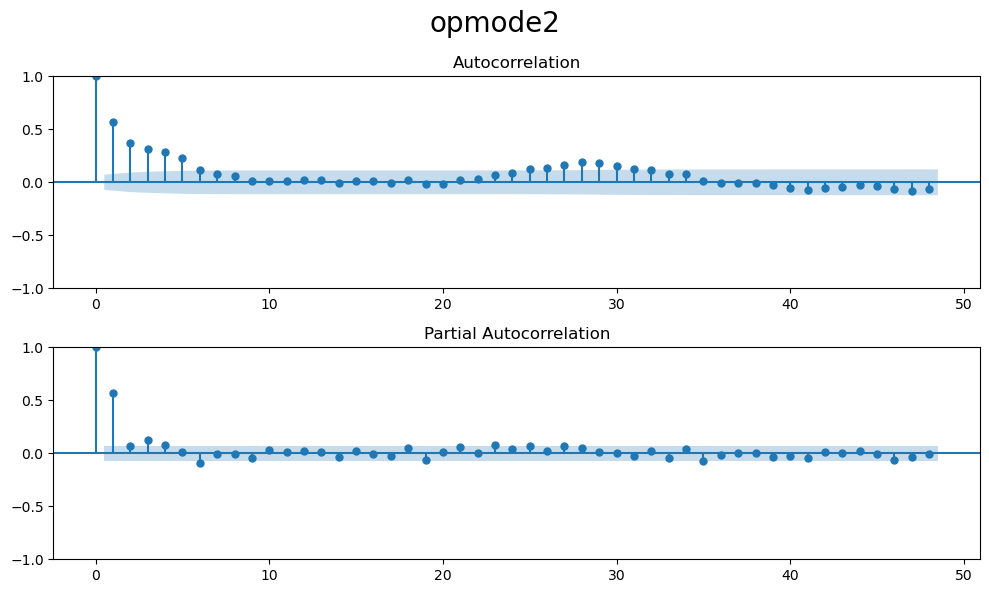

/home/deallab/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


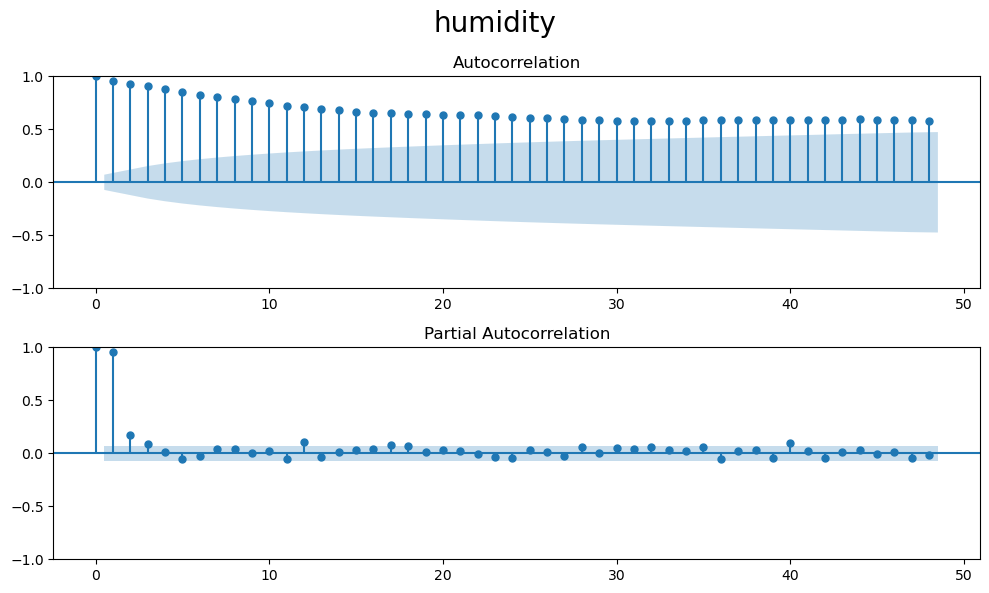

/home/deallab/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


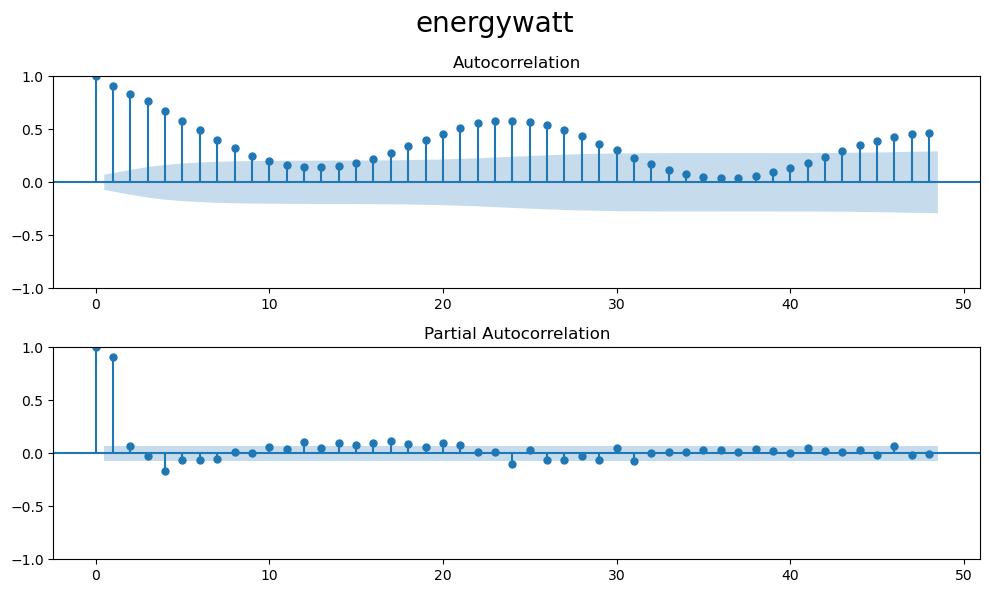

/home/deallab/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


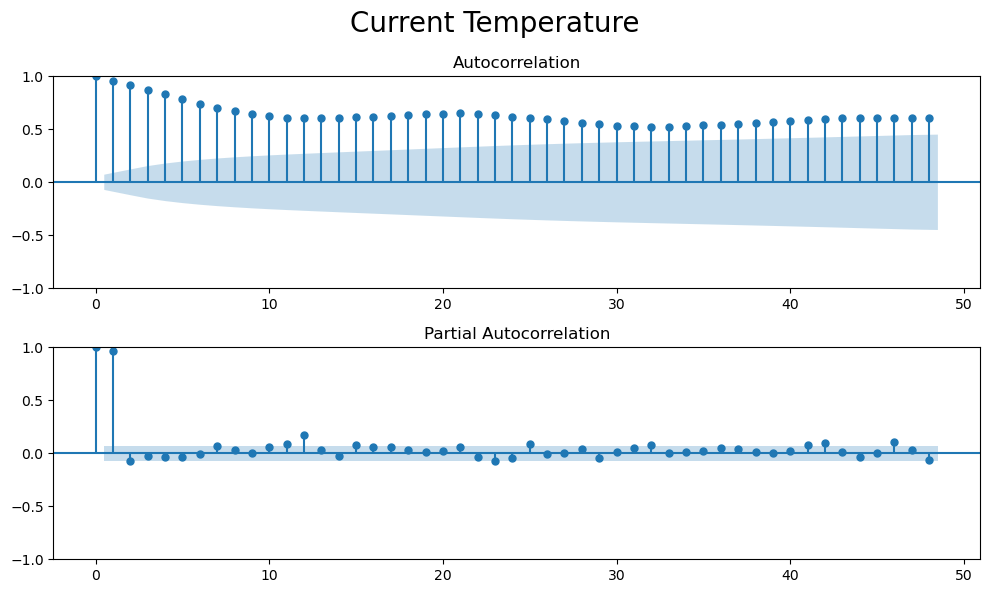

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df['airstate.opmode2'], lags=48, ax=ax1)
plot_pacf(df['airstate.opmode2'], lags=48, ax=ax2)
plt.suptitle('opmode2',size=20)
plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df['humidity'], lags=48, ax=ax1)
plot_pacf(df['humidity'], lags=48, ax=ax2)
plt.suptitle('humidity',size=20)
plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df['energywatt'], lags=48, ax=ax1)
plot_pacf(df['energywatt'], lags=48, ax=ax2)
plt.suptitle('energywatt',size=20)
plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df['currenttemperature'], lags=48, ax=ax1)
plot_pacf(df['currenttemperature'], lags=48, ax=ax2)
plt.suptitle('Current Temperature',size=20)
plt.tight_layout()
plt.show()

In [56]:
# 한시간 전 
cols= ['humidity', 'currenttemperature',
       'airstate.tempstate.target', 'pm1', 'pm2', 'pm10', 'sensory_temp',
       'airstate.opmode', 'airstate.windstrength', 'airstate.opmode2','DI']
# 한시간 전 데이터를 변수로 추가
for col in cols:
    df[f"prior_{col}"] = df[col].shift(1)
    df[f"diff_{col}"] = df[col] - df[col].shift(1)

df = df.iloc[1:,:]
cols = ['prior_airstate.windstrength','prior_airstate.opmode2','diff_airstate.windstrength'] # 범주형 변수 타입 변경
df = df.drop(['diff_airstate.opmode','diff_airstate.opmode2','day','energywatt','prior_airstate.opmode'],axis=1) # 필요없는 변수 제거
# energywatt같은 경우 USER가 기기 조작시에 알 수 없는 데이터이므로 모델에서 제거
# 차이변수 생성
df = df.drop(['airstate.windstrength','airstate.tempstate.target'], axis = 1) # diff 변수에 영향이 들어가므로 제거
for col in cols:
    df[col] = df[col].astype('int')

In [57]:
df['airstate.opmode2'].value_counts()

0    423
1    320
Name: airstate.opmode2, dtype: int64

In [58]:
md_df1=df.loc[df['prior_airstate.opmode2']==0] # 이전 제습모드가 0인 df
md_df2=df.loc[df['prior_airstate.opmode2']==1] # 이전 제습모드가 1인 df

# 모델 1 : 이전 제습모드가 0

In [77]:
# 제습모드 분류를 위한 X,y 설정
X = md_df1.loc[:,df.columns.difference(['airstate.opmode2','airstate.opmode','prior_airstate.opmode2'])]
y = md_df1.loc[:,'airstate.opmode2']
# X = df.loc[:,df.columns.difference(['airstate.opmode2','airstate.opmode'])]
# y = df.loc[:,'airstate.opmode2']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [78]:
y.value_counts() 

0    344
1     79
Name: airstate.opmode2, dtype: int64

In [79]:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

# 모델설정
sm = SMOTE(random_state=1) # 가장 정확도 높음
ad = ADASYN(random_state=1)
rs = RandomOverSampler(random_state=1)

# train데이터를 넣어 복제함
X_resampled, y_resampled = sm.fit_sample(X_train,list(y_train))

In [80]:
sum(y_resampled)/len(y_resampled)

0.5

In [81]:
xgb = XGBClassifier(n_estimators=100,random_state=42)
# 후보 파라미터 선정
params = {'max_depth':range(4,10,2),'learning_rate':np.arange(0.01,0.2,0.01), 'min_child_weight':[1,3], 'colsample_bytree':[0.5,1]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridcv = GridSearchCV(xgb, param_grid=params, cv=3,n_jobs=-1)

# 파라미터 튜닝 시작
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='error', eval_set=[(X_test, y_test)])

#튜닝된 파라미터 출력
print(gridcv.best_params_)

/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in construct

[0]	validation_0-error:0.24706
[1]	validation_0-error:0.23529
[2]	validation_0-error:0.23529
[3]	validation_0-error:0.23529
[4]	validation_0-error:0.23529
[5]	validation_0-error:0.23529
[0]	validation_0-error:0.24706
[0]	validation_0-error:0.27059
[0]	validation_0-error:0.28235
[1]	validation_0-error:0.28235
[1]	validation_0-error:0.25882
[6]	validation_0-error:0.23529
[1]	validation_0-error:0.27059
[2]	validation_0-error:0.27059
[2]	validation_0-error:0.24706
[2]	validation_0-error:0.24706
[3]	validation_0-error:0.27059
[3]	validation_0-error:0.25882
[7]	validation_0-error:0.23529
[3]	validation_0-error:0.25882
[4]	validation_0-error:0.24706
[4]	validation_0-error:0.27059
[4]	validation_0-error:0.24706
[0]	validation_0-error:0.22353
[8]	validation_0-error:0.23529
[5]	validation_0-error:0.24706
[5]	validation_0-error:0.25882
[5]	validation_0-error:0.24706
[6]	validation_0-error:0.24706
[6]	validation_0-error:0.25882
[1]	validation_0-error:0.25882
[9]	validation_0-error:0.23529
[6]	vali

eallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`s

rror:0.24706
[17]	validation_0-error:0.24706
[6]	validation_0-error:0.23529
[2]	validation_0-error:0.28235
[33]	validation_0-error:0.25882
[34]	validation_0-error:0.25882
[28]	validation_0-error:0.23529
[22]	validation_0-error:0.24706
[13]	validation_0-error:0.24706
[20]	validation_0-error:0.25882
[11]	validation_0-error:0.24706
[24]	validation_0-error:0.27059
[3]	validation_0-error:0.25882
[18]	validation_0-error:0.23529
[22]	validation_0-error:0.24706
[7]	validation_0-error:0.23529
[3]	validation_0-error:0.24706
[1]	validation_0-error:0.23529
[23]	validation_0-error:0.23529
[21]	validation_0-error:0.25882
[34]	validation_0-error:0.24706
[4]	validation_0-error:0.27059
[19]	validation_0-error:0.25882
[25]	validation_0-error:0.25882
[8]	validation_0-error:0.23529
[29]	validation_0-error:0.22353
[23]	validation_0-error:0.24706
[14]	validation_0-error:0.24706
[22]	validation_0-error:0.25882
[12]	validation_0-error:0.24706
[24]	validation_0-error:0.23529
[5]	validation_0-error:0.25882
[20]

[6]	validation_0-error:0.25882
[19]	validation_0-error:0.24706
[21]	validation_0-error:0.23529
[20]	validation_0-error:0.24706
[34]	validation_0-error:0.25882
[7]	validation_0-error:0.25882
[54]	validation_0-error:0.23529
[15]	validation_0-error:0.23529
[8]	validation_0-error:0.22353
[9]	validation_0-error:0.23529
[3]	validation_0-error:0.27059
[7]	validation_0-error:0.25882
[31]	validation_0-error:0.25882
[12]	validation_0-error:0.24706
[20]	validation_0-error:0.25882
[24]	validation_0-error:0.23529
[16]	validation_0-error:0.23529
[55]	validation_0-error:0.23529
[22]	validation_0-error:0.24706
[0]	validation_0-error:0.28235
[35]	validation_0-error:0.25882
[8]	validation_0-error:0.22353
[10]	validation_0-error:0.23529
[8]	validation_0-error:0.23529
[21]	validation_0-error:0.24706
[0]	validation_0-error:0.23529
[4]	validation_0-error:0.27059
[13]	validation_0-error:0.23529
[17]	validation_0-error:0.23529
[9]	validation_0-error:0.23529
[9]	validation_0-error:0.22353
[32]	validation_0-err

s` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_

	validation_0-error:0.22353
[14]	validation_0-error:0.25882
[20]	validation_0-error:0.25882
[21]	validation_0-error:0.24706
[33]	validation_0-error:0.23529
[13]	validation_0-error:0.22353
[27]	validation_0-error:0.25882
[24]	validation_0-error:0.24706
[3]	validation_0-error:0.25882
[22]	validation_0-error:0.24706
[10]	validation_0-error:0.22353
[21]	validation_0-error:0.25882
[15]	validation_0-error:0.25882
[20]	validation_0-error:0.25882
[22]	validation_0-error:0.23529
[0]	validation_0-error:0.24706
[46]	validation_0-error:0.22353
[28]	validation_0-error:0.25882
[34]	validation_0-error:0.23529
[23]	validation_0-error:0.23529
[22]	validation_0-error:0.25882
[25]	validation_0-error:0.23529
[11]	validation_0-error:0.24706
[4]	validation_0-error:0.25882
[14]	validation_0-error:0.23529
[16]	validation_0-error:0.25882
[23]	validation_0-error:0.23529
[21]	validation_0-error:0.25882
[1]	validation_0-error:0.24706
[47]	validation_0-error:0.22353
[29]	validation_0-error:0.25882
[23]	validation_

 warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metr

ation_0-error:0.22353
[10]	validation_0-error:0.27059
[6]	validation_0-error:0.23529
[27]	validation_0-error:0.22353
[19]	validation_0-error:0.22353
[13]	validation_0-error:0.24706
[3]	validation_0-error:0.25882
[24]	validation_0-error:0.27059
[58]	validation_0-error:0.21176
[21]	validation_0-error:0.20000
[45]	validation_0-error:0.22353
[8]	validation_0-error:0.22353
[28]	validation_0-error:0.27059
[2]	validation_0-error:0.27059
[2]	validation_0-error:0.23529
[7]	validation_0-error:0.22353
[42]	validation_0-error:0.20000
[4]	validation_0-error:0.24706
[12]	validation_0-error:0.24706
[19]	validation_0-error:0.24706
[66]	validation_0-error:0.21176
[25]	validation_0-error:0.21176
[26]	validation_0-error:0.22353
[22]	validation_0-error:0.22353
[11]	validation_0-error:0.23529
[4]	validation_0-error:0.25882
[20]	validation_0-error:0.22353
[22]	validation_0-error:0.27059
[7]	validation_0-error:0.24706
[14]	validation_0-error:0.25882
[3]	validation_0-error:0.25882
[1]	validation_0-error:0.247

ng_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboos

	validation_0-error:0.21176
[1]	validation_0-error:0.23529
[48]	validation_0-error:0.20000
[34]	validation_0-error:0.27059
[11]	validation_0-error:0.22353
[28]	validation_0-error:0.25882
[7]	validation_0-error:0.23529
[38]	validation_0-error:0.22353
[31]	validation_0-error:0.23529
[30]	validation_0-error:0.21176
[6]	validation_0-error:0.27059
[18]	validation_0-error:0.23529
[36]	validation_0-error:0.21176
[11]	validation_0-error:0.25882
[0]	validation_0-error:0.25882
[40]	validation_0-error:0.22353
[38]	validation_0-error:0.21176
[25]	validation_0-error:0.25882
[12]	validation_0-error:0.23529
[49]	validation_0-error:0.20000
[29]	validation_0-error:0.25882
[28]	validation_0-error:0.21176
[8]	validation_0-error:0.25882
[24]	validation_0-error:0.21176
[2]	validation_0-error:0.23529
[31]	validation_0-error:0.21176
[13]	validation_0-error:0.24706
[39]	validation_0-error:0.22353
[37]	validation_0-error:0.21176
[32]	validation_0-error:0.23529
[19]	validation_0-error:0.22353
[12]	validation_0-

/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in construct

dation_0-error:0.28235
[6]	validation_0-error:0.28235
[13]	validation_0-error:0.27059
[8]	validation_0-error:0.24706
[3]	validation_0-error:0.24706
[14]	validation_0-error:0.23529
[23]	validation_0-error:0.23529
[15]	validation_0-error:0.28235
[7]	validation_0-error:0.24706
[25]	validation_0-error:0.25882
[6]	validation_0-error:0.23529
[23]	validation_0-error:0.23529
[0]	validation_0-error:0.29412
[5]	validation_0-error:0.24706
[24]	validation_0-error:0.23529
[9]	validation_0-error:0.24706
[7]	validation_0-error:0.28235
[25]	validation_0-error:0.23529
[14]	validation_0-error:0.25882
[7]	validation_0-error:0.23529
[8]	validation_0-error:0.28235
[14]	validation_0-error:0.27059
[26]	validation_0-error:0.25882
[21]	validation_0-error:0.25882
[8]	validation_0-error:0.24706
[23]	validation_0-error:0.24706
[4]	validation_0-error:0.27059
[26]	validation_0-error:0.23529
[16]	validation_0-error:0.28235
[15]	validation_0-error:0.23529
[24]	validation_0-error:0.23529
[6]	validation_0-error:0.24706

/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in construct

tion_0-error:0.22353
[13]	validation_0-error:0.27059
[14]	validation_0-error:0.23529
[5]	validation_0-error:0.24706
[24]	validation_0-error:0.23529
[24]	validation_0-error:0.25882
[24]	validation_0-error:0.24706
[14]	validation_0-error:0.24706
[36]	validation_0-error:0.22353
[0]	validation_0-error:0.24706
[22]	validation_0-error:0.24706
[48]	validation_0-error:0.23529
[23]	validation_0-error:0.24706
[31]	validation_0-error:0.23529
[13]	validation_0-error:0.24706
[45]	validation_0-error:0.23529
[10]	validation_0-error:0.24706
[24]	validation_0-error:0.27059
[15]	validation_0-error:0.23529
[35]	validation_0-error:0.22353
[32]	validation_0-error:0.25882
[23]	validation_0-error:0.24706
[58]	validation_0-error:0.22353
[25]	validation_0-error:0.24706
[1]	validation_0-error:0.24706
[21]	validation_0-error:0.25882
[25]	validation_0-error:0.25882
[14]	validation_0-error:0.27059
[6]	validation_0-error:0.24706
[2]	validation_0-error:0.24706
[23]	validation_0-error:0.24706
[27]	validation_0-error:

/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in construct

[52]	validation_0-error:0.18824
[9]	validation_0-error:0.24706
[10]	validation_0-error:0.25882
[19]	validation_0-error:0.23529
[51]	validation_0-error:0.18824
[52]	validation_0-error:0.21176
[83]	validation_0-error:0.18824
[42]	validation_0-error:0.23529
[69]	validation_0-error:0.22353
[3]	validation_0-error:0.23529
[3]	validation_0-error:0.27059
[26]	validation_0-error:0.22353
[22]	validation_0-error:0.24706
[16]	validation_0-error:0.24706
[68]	validation_0-error:0.21176
[3]	validation_0-error:0.27059
[0]	validation_0-error:0.29412
[29]	validation_0-error:0.24706
[28]	validation_0-error:0.29412
[9]	validation_0-error:0.25882
[31]	validation_0-error:0.23529
[19]	validation_0-error:0.22353
[53]	validation_0-error:0.18824
[54]	validation_0-error:0.24706
[11]	validation_0-error:0.25882
[7]	validation_0-error:0.25882
[52]	validation_0-error:0.18824
[84]	validation_0-error:0.18824
[53]	validation_0-error:0.22353
[0]	validation_0-error:0.24706
[69]	validation_0-error:0.21176
[11]	validation_

[27]	validation_0-error:0.25882
[24]	validation_0-error:0.21176
[29]	validation_0-error:0.23529
[85]	validation_0-error:0.21176
[10]	validation_0-error:0.23529
[40]	validation_0-error:0.23529
[95]	validation_0-error:0.17647
[25]	validation_0-error:0.25882
[33]	validation_0-error:0.24706
[46]	validation_0-error:0.23529
[35]	validation_0-error:0.25882
[18]	validation_0-error:0.21176
[69]	validation_0-error:0.18824
[1]	validation_0-error:0.25882
[38]	validation_0-error:0.21176
[54]	validation_0-error:0.23529
[34]	validation_0-error:0.28235
[6]	validation_0-error:0.24706
[86]	validation_0-error:0.21176
[96]	validation_0-error:0.17647
[34]	validation_0-error:0.20000
[7]	validation_0-error:0.25882
[5]	validation_0-error:0.23529
[29]	validation_0-error:0.24706
[21]	validation_0-error:0.23529
[10]	validation_0-error:0.25882
[31]	validation_0-error:0.23529
[22]	validation_0-error:0.22353
[11]	validation_0-error:0.23529
[41]	validation_0-error:0.24706
[39]	validation_0-error:0.22353
[28]	validat

/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in construct

[13]	validation_0-error:0.23529
[1]	validation_0-error:0.24706
[15]	validation_0-error:0.25882
[3]	validation_0-error:0.25882
[34]	validation_0-error:0.28235
[9]	validation_0-error:0.22353
[17]	validation_0-error:0.24706
[25]	validation_0-error:0.23529
[43]	validation_0-error:0.25882
[37]	validation_0-error:0.20000
[30]	validation_0-error:0.28235
[6]	validation_0-error:0.25882
[0]	validation_0-error:0.24706
[4]	validation_0-error:0.25882
[15]	validation_0-error:0.25882
[24]	validation_0-error:0.17647
[34]	validation_0-error:0.24706
[24]	validation_0-error:0.22353
[26]	validation_0-error:0.23529
[13]	validation_0-error:0.24706
[22]	validation_0-error:0.27059
[25]	validation_0-error:0.25882
[9]	validation_0-error:0.23529
[10]	validation_0-error:0.22353
[17]	validation_0-error:0.27059
[35]	validation_0-error:0.27059
[6]	validation_0-error:0.24706
[26]	validation_0-error:0.23529
[14]	validation_0-error:0.23529
[38]	validation_0-error:0.20000
[2]	validation_0-error:0.23529
[16]	validation_0

/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in construct

[38]	validation_0-error:0.22353
[51]	validation_0-error:0.18824
[52]	validation_0-error:0.21176
[35]	validation_0-error:0.22353
[47]	validation_0-error:0.24706
[22]	validation_0-error:0.23529
[21]	validation_0-error:0.23529
[26]	validation_0-error:0.23529
[39]	validation_0-error:0.23529
[6]	validation_0-error:0.24706
[55]	validation_0-error:0.21176
[42]	validation_0-error:0.22353
[32]	validation_0-error:0.25882
[8]	validation_0-error:0.24706
[22]	validation_0-error:0.18824
[13]	validation_0-error:0.24706
[37]	validation_0-error:0.24706
[48]	validation_0-error:0.24706
[12]	validation_0-error:0.21176
[38]	validation_0-error:0.20000
[52]	validation_0-error:0.18824
[27]	validation_0-error:0.23529
[56]	validation_0-error:0.20000
[7]	validation_0-error:0.23529
[39]	validation_0-error:0.22353
[49]	validation_0-error:0.24706
[36]	validation_0-error:0.22353
[33]	validation_0-error:0.25882
[11]	validation_0-error:0.23529
[28]	validation_0-error:0.23529
[23]	validation_0-error:0.23529
[43]	valida

[0]	validation_0-error:0.21176
[1]	validation_0-error:0.24706
[2]	validation_0-error:0.24706
[3]	validation_0-error:0.20000
[4]	validation_0-error:0.24706
[5]	validation_0-error:0.23529
[6]	validation_0-error:0.23529
[7]	validation_0-error:0.22353
[8]	validation_0-error:0.22353
[9]	validation_0-error:0.22353
[10]	validation_0-error:0.21176
[11]	validation_0-error:0.21176
[12]	validation_0-error:0.21176
[13]	validation_0-error:0.22353
[14]	validation_0-error:0.22353
[15]	validation_0-error:0.22353
[16]	validation_0-error:0.22353
[17]	validation_0-error:0.23529
[18]	validation_0-error:0.24706
[19]	validation_0-error:0.23529
[20]	validation_0-error:0.23529
[21]	validation_0-error:0.23529
[22]	validation_0-error:0.24706
[23]	validation_0-error:0.23529
[24]	validation_0-error:0.22353
[25]	validation_0-error:0.22353
[26]	validation_0-error:0.22353
[27]	validation_0-error:0.22353
[28]	validation_0-error:0.21176
[29]	validation_0-error:0.22353
[30]	validation_0-error:0.22353
[31]	validation_0-

In [82]:
xgb = XGBClassifier(n_estimators=100,colsample_bytree=0.5, max_depth=6, min_child_weight = 3,learning_rate=0.17,random_state=42)

xgb.fit(X_train, y_train, early_stopping_rounds=200, eval_metric='error', eval_set=[(X_test, y_test)])

/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.21176
[1]	validation_0-error:0.24706
[2]	validation_0-error:0.24706
[3]	validation_0-error:0.20000
[4]	validation_0-error:0.24706
[5]	validation_0-error:0.23529
[6]	validation_0-error:0.23529
[7]	validation_0-error:0.22353
[8]	validation_0-error:0.22353
[9]	validation_0-error:0.22353
[10]	validation_0-error:0.21176
[11]	validation_0-error:0.21176
[12]	validation_0-error:0.21176
[13]	validation_0-error:0.22353
[14]	validation_0-error:0.22353
[15]	validation_0-error:0.22353
[16]	validation_0-error:0.22353
[17]	validation_0-error:0.23529
[18]	validation_0-error:0.24706
[19]	validation_0-error:0.23529
[20]	validation_0-error:0.23529
[21]	validation_0-error:0.23529
[22]	validation_0-error:0.24706
[23]	validation_0-error:0.23529
[24]	validation_0-error:0.22353
[25]	validation_0-error:0.22353
[26]	validation_0-error:0.22353
[27]	validation_0-error:0.22353
[28]	validation_0-error:0.21176
[29]	validation_0-error:0.22353
[30]	validation_0-error:0.22353
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.17, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [83]:
y_pred = xgb.predict(X_test)

print(accuracy_score(y_test,y_pred))

0.8


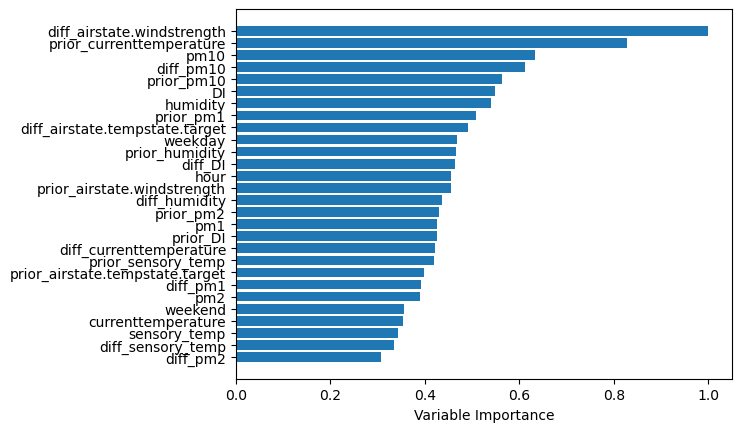

In [84]:
names = X.columns
featureImportance = xgb.feature_importances_

#가장 높은 중요도 기준으로 스케일링
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, names[sorted_idx])
plt.xlabel('Variable Importance')
plt.show()

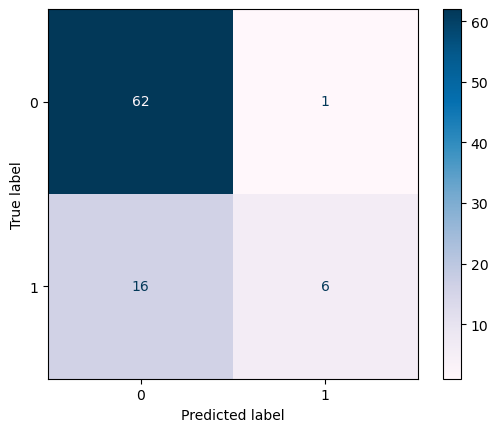

In [92]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
plot_confusion_matrix(xgb, X_test, y_test,
                         include_values = True,
                         display_labels = ['0', '1'], # 목표변수 이름
                         cmap = 'PuBu') # 컬러맵

In [86]:
rf = RandomForestClassifier(random_state=42)
# 그리드 서치
param_grid = [{'n_estimators':[100],'max_features':range(1,10),'max_depth':range(4,12,2)}]
gs = GridSearchCV(rf,param_grid = param_grid, scoring='accuracy',cv = 3, n_jobs=-1,verbose=2)
gs.fit(X_resampled,y_resampled)
print('random forest parameter : ',gs.best_params_) # 최적 파라미터

Fitting 3 folds for each of 36 candidates, totalling 108 fits
random forest parameter :  {'max_depth': 10, 'max_features': 4, 'n_estimators': 100}


In [87]:
rf = RandomForestClassifier(max_depth=10, max_features=4, n_estimators=100,random_state=42)
rf_model=rf.fit(X_resampled,y_resampled)

In [88]:
y_pred = rf_model.predict(X_test)

print(accuracy_score(y_test,y_pred))

0.7294117647058823


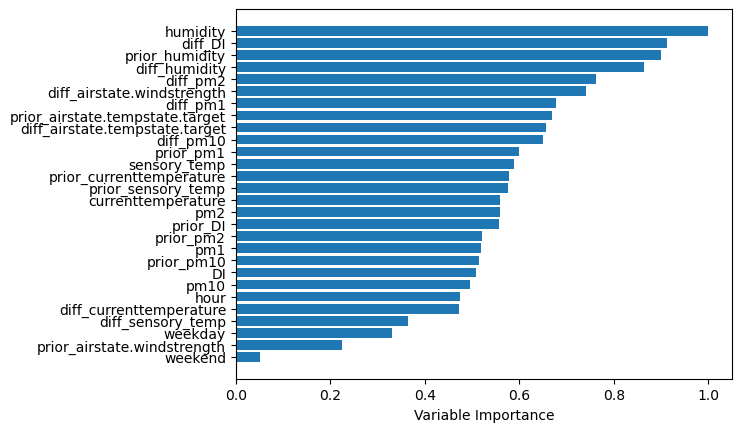

In [89]:
names = X.columns
featureImportance = rf.feature_importances_

#가장 높은 중요도 기준으로 스케일링
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, names[sorted_idx])
plt.xlabel('Variable Importance')
plt.show()

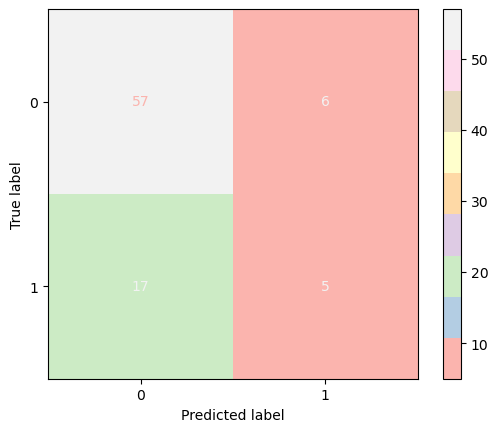

[CV] END ......max_depth=4, max_features=5, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=6, max_features=8, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=8, max_features=6, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=4, max_features=5, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=8, max_features=1, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=8, max_features=6, n_estimators=100; total time=   0.4s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=4, max_features=1, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=8, max_features=3, n_estimators=100; total time=   0.3s
[CV] END .....max_depth=10, max_features=1, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=6, max_features=1, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=8, max_features=2, n_estimators=100; total time=   0.3s
[CV] END .....max_depth=10, max_features=2, n_estimators=100; total time=   0.3s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=6, max_features=5, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=4, max_features=9, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=8, max_features=8, n_estimators=100; total time=   0.4s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=4, max_features=6, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=8, max_features=7, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=4, max_features=4, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=8, max_features=2, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=8, max_features=9, n_estimators=100; total time=   0.4s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=4, max_features=7, n_estimators=100; total time=   0.4s
[CV] END .....max_depth=10, max_features=2, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=4, max_features=9, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=8, max_features=3, n_estimators=100; total time=   0.3s
[CV] END .....max_depth=10, max_features=2, n_estimators=100; total time=   0.4s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=4, max_features=3, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=6, max_features=8, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=8, max_features=7, n_estimators=100; total time=   0.5s
[CV] END ......max_depth=4, max_features=4, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=6, max_features=8, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=8, max_features=8, n_estimators=100; total time=   0.4s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=6, max_features=3, n_estimators=100; total time=   0.3s
[CV] END .....max_depth=10, max_features=3, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=4, max_features=2, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=8, max_features=9, n_estimators=100; total time=   0.4s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=6, max_features=4, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=6, max_features=1, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=8, max_features=2, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=8, max_features=8, n_estimators=100; total time=   0.4s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=4, max_features=6, n_estimators=100; total time=   0.5s
[CV] END ......max_depth=8, max_features=4, n_estimators=100; total time=   0.3s
[CV] END .....max_depth=10, max_features=3, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=4, max_features=6, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=6, max_features=9, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=8, max_features=9, n_estimators=100; total time=   0.4s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=6, max_features=2, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=8, max_features=4, n_estimators=100; total time=   0.3s
[CV] END .....max_depth=10, max_features=3, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=6, max_features=3, n_estimators=100; total time=   0.3s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=4, max_features=8, n_estimators=100; total time=   0.5s
[CV] END .....max_depth=10, max_features=1, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=4, max_features=1, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=6, max_features=9, n_estimators=100; total time=   0.5s
[CV] END .....max_depth=10, max_features=4, n_estimators=100; total time=   0.3s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=4, max_features=2, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=6, max_features=7, n_estimators=100; total time=   0.6s
[CV] END .....max_depth=10, max_features=4, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=4, max_features=9, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=8, max_features=3, n_estimators=100; total time=   0.4s
[CV] END .....max_depth=10, max_features=4, n_estimators=100; total time=   0.3s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=4, max_features=4, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=8, max_features=1, n_estimators=100; total time=   0.5s
[CV] END .....max_depth=10, max_features=5, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=4, max_features=8, n_estimators=100; total time=   0.6s
[CV] END .....max_depth=10, max_features=5, n_estimators=100; total time=   0.4s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=4, max_features=3, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=6, max_features=7, n_estimators=100; total time=   0.7s
[CV] END .....max_depth=10, max_features=6, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=4, max_features=3, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=6, max_features=9, n_estimators=100; total time=   0.5s
[CV] END .....max_depth=10, max_features=6, n_estimators=100; total time=   0.4s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=6, max_features=5, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=4, max_features=1, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=6, max_features=1, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=6, max_features=2, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=6, max_features=6, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=6, max_features=6, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=6, max_features=6, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=8, max_features=5, n_estimators=100; total time=   0.3s
[CV] END .....max_depth=10, max_features=6, n_estimators=100; total time=   0.4s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=6, max_features=2, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=8, max_features=5, n_estimators=100; total time=   0.3s
[CV] END .....max_depth=10, max_features=7, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=6, max_features=4, n_estimators=100; total time=   0.3s
[CV] END .....max_depth=10, max_features=8, n_estimators=100; total time=   0.3s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=6, max_features=3, n_estimators=100; total time=   0.3s
[CV] END .....max_depth=10, max_features=5, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=4, max_features=7, n_estimators=100; total time=   0.4s
[CV] END .....max_depth=10, max_features=1, n_estimators=100; total time=   0.3s
[CV] END .....max_depth=10, max_features=8, n_estimators=100; total time=   0.3s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=6, max_features=4, n_estimators=100; total time=   0.4s
[CV] END .....max_depth=10, max_features=7, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=4, max_features=2, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=6, max_features=7, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=8, max_features=6, n_estimators=100; total time=   0.4s
[CV] END .....max_depth=10, max_features=9, n_estimators=100; total time=   0.3s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=6, max_features=5, n_estimators=100; total time=   0.3s
[CV] END .....max_depth=10, max_features=9, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=4, max_features=8, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=8, max_features=5, n_estimators=100; total time=   0.3s
[CV] END .....max_depth=10, max_features=8, n_estimators=100; total time=   0.4s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=4, max_features=7, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=8, max_features=4, n_estimators=100; total time=   0.5s
[CV] END .....max_depth=10, max_features=7, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=4, max_features=5, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=8, max_features=1, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=8, max_features=7, n_estimators=100; total time=   0.4s
[CV] END .....max_depth=10, max_features=9, n_estimators=100; total time=   0.4s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [90]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
plot_confusion_matrix(rf, X_test, y_test,
                         include_values = True,
                         display_labels = ['0', '1'], # 목표변수 이름
                         cmap = 'Pastel1') # 컬러맵

array([0.03149978, 0.04489929, 0.04963266, 0.04127768, 0.07428243,
       0.04619842, 0.03461005, 0.04328267, 0.03415965, 0.03282487,
       0.08361953, 0.03316174, 0.03106984, 0.03098273, 0.05169906,
       0.01571254, 0.05000898, 0.06755715, 0.035034  , 0.04224027,
       0.03714968, 0.04141799, 0.04207026, 0.00560872])

# 모델 2 : 이전 제습모드가 1

In [99]:
# 제습모드 분류를 위한 X,y 설정
X = md_df2.loc[:,df.columns.difference(['airstate.opmode2','airstate.opmode','prior_airstate.opmode2'])]
y = md_df2.loc[:,'airstate.opmode2']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [102]:
y.value_counts()

1    241
0     79
Name: airstate.opmode2, dtype: int64

In [101]:
from imblearn.over_sampling import SMOTE

# 모델설정
sm = SMOTE()

# train데이터를 넣어 복제함
X_resampled, y_resampled = sm.fit_sample(X_train,list(y_train))

In [96]:
xgb = XGBClassifier(n_estimators=100,random_state=42)
# 후보 파라미터 선정
params = {'max_depth':range(4,10,2),'learning_rate':np.arange(0.01,0.2,0.01), 'min_child_weight':[1,3], 'colsample_bytree':[0.5,1]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridcv = GridSearchCV(xgb, param_grid=params, cv=3,n_jobs=-1)

# 파라미터 튜닝 시작
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='error', eval_set=[(X_test, y_test)])

#튜닝된 파라미터 출력
print(gridcv.best_params_)

[0]	validation_0-error:0.32812
[1]	validation_0-error:0.31250
[2]	validation_0-error:0.28125
[3]	validation_0-error:0.31250
[4]	validation_0-error:0.29688
[5]	validation_0-error:0.28125
[6]	validation_0-error:0.31250
[7]	validation_0-error:0.31250
[8]	validation_0-error:0.29688
[9]	validation_0-error:0.29688
[10]	validation_0-error:0.29688
[11]	validation_0-error:0.29688
[12]	validation_0-error:0.29688
[13]	validation_0-error:0.29688
[14]	validation_0-error:0.29688
[15]	validation_0-error:0.29688
[16]	validation_0-error:0.28125
[17]	validation_0-error:0.28125
[18]	validation_0-error:0.28125
[19]	validation_0-error:0.28125
[20]	validation_0-error:0.28125
[21]	validation_0-error:0.28125
[22]	validation_0-error:0.28125
[23]	validation_0-error:0.29688
[24]	validation_0-error:0.29688
[25]	validation_0-error:0.29688
[26]	validation_0-error:0.29688
[27]	validation_0-error:0.29688
[28]	validation_0-error:0.29688
[29]	validation_0-error:0.31250
[30]	validation_0-error:0.29688
[31]	validation_0-

[0]	validation_0-error:0.35938
[1]	validation_0-error:0.39062
[2]	validation_0-error:0.35938
[3]	validation_0-error:0.32812
[4]	validation_0-error:0.34375
[5]	validation_0-error:0.32812
[6]	validation_0-error:0.32812
[7]	validation_0-error:0.32812
[8]	validation_0-error:0.31250
[9]	validation_0-error:0.29688
[10]	validation_0-error:0.29688
[11]	validation_0-error:0.28125
[12]	validation_0-error:0.29688
[13]	validation_0-error:0.29688
[14]	validation_0-error:0.29688
[15]	validation_0-error:0.32812
[16]	validation_0-error:0.29688
[17]	validation_0-error:0.29688
[18]	validation_0-error:0.29688
[19]	validation_0-error:0.31250
[20]	validation_0-error:0.31250
[21]	validation_0-error:0.31250
[22]	validation_0-error:0.32812
[23]	validation_0-error:0.35938
[24]	validation_0-error:0.35938
[25]	validation_0-error:0.35938
[26]	validation_0-error:0.32812
[27]	validation_0-error:0.32812
[28]	validation_0-error:0.34375
[29]	validation_0-error:0.34375
[30]	validation_0-error:0.34375
[31]	validation_0-

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/

[0]	validation_0-error:0.34375
[1]	validation_0-error:0.40625
[0]	validation_0-error:0.34375
[2]	validation_0-error:0.34375
[1]	validation_0-error:0.40625
[3]	validation_0-error:0.37500
[2]	validation_0-error:0.34375
[4]	validation_0-error:0.34375
[3]	validation_0-error:0.37500
[5]	validation_0-error:0.35938
[4]	validation_0-error:0.34375
[6]	validation_0-error:0.35938
[5]	validation_0-error:0.35938
[7]	validation_0-error:0.32812
[6]	validation_0-error:0.34375
[8]	validation_0-error:0.34375
[7]	validation_0-error:0.34375
[9]	validation_0-error:0.34375
[8]	validation_0-error:0.34375
[10]	validation_0-error:0.34375
[9]	validation_0-error:0.34375
[11]	validation_0-error:0.35938
[10]	validation_0-error:0.34375
[12]	validation_0-error:0.34375
[11]	validation_0-error:0.35938
[13]	validation_0-error:0.35938
[12]	validation_0-error:0.34375
[14]	validation_0-error:0.35938
[13]	validation_0-error:0.35938
[15]	validation_0-error:0.35938
[14]	validation_0-error:0.35938
[16]	validation_0-error:0.35

[18]	validation_0-error:0.31250
[34]	validation_0-error:0.31250
[23]	validation_0-error:0.29688
[19]	validation_0-error:0.29688
[24]	validation_0-error:0.29688
[35]	validation_0-error:0.32812
[20]	validation_0-error:0.29688
[25]	validation_0-error:0.29688
[36]	validation_0-error:0.34375
[21]	validation_0-error:0.29688
[26]	validation_0-error:0.29688
[37]	validation_0-error:0.32812
[22]	validation_0-error:0.29688
[27]	validation_0-error:0.29688
[23]	validation_0-error:0.29688
[38]	validation_0-error:0.31250
[28]	validation_0-error:0.29688
[24]	validation_0-error:0.31250
[39]	validation_0-error:0.32812
[29]	validation_0-error:0.29688
[25]	validation_0-error:0.31250
[40]	validation_0-error:0.32812
[26]	validation_0-error:0.31250
[41]	validation_0-error:0.31250
[27]	validation_0-error:0.31250
[28]	validation_0-error:0.31250
[29]	validation_0-error:0.31250
[30]	validation_0-error:0.31250
[0]	validation_0-error:0.28125
[1]	validation_0-error:0.32812
[2]	validation_0-error:0.29688
[3]	validat

[13]	validation_0-error:0.35938
[42]	validation_0-error:0.29688
[43]	validation_0-error:0.29688
[14]	validation_0-error:0.35938
[44]	validation_0-error:0.29688
[45]	validation_0-error:0.29688
[15]	validation_0-error:0.34375
[46]	validation_0-error:0.29688
[16]	validation_0-error:0.34375
[47]	validation_0-error:0.29688
[17]	validation_0-error:0.34375
[48]	validation_0-error:0.29688
[49]	validation_0-error:0.29688
[18]	validation_0-error:0.34375
[50]	validation_0-error:0.29688
[51]	validation_0-error:0.29688
[19]	validation_0-error:0.34375
[52]	validation_0-error:0.29688
[20]	validation_0-error:0.35938
[53]	validation_0-error:0.29688
[21]	validation_0-error:0.35938
[54]	validation_0-error:0.29688
[0]	validation_0-error:0.35938
[22]	validation_0-error:0.35938
[1]	validation_0-error:0.39062
[23]	validation_0-error:0.35938
[2]	validation_0-error:0.35938
[3]	validation_0-error:0.32812
[24]	validation_0-error:0.35938
[4]	validation_0-error:0.34375
[25]	validation_0-error:0.35938
[5]	validatio

/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in construct

[9]	validation_0-error:0.29688
[36]	validation_0-error:0.31250
[5]	validation_0-error:0.28125
[37]	validation_0-error:0.31250
[6]	validation_0-error:0.28125
[10]	validation_0-error:0.29688
[7]	validation_0-error:0.29688
[11]	validation_0-error:0.29688
[8]	validation_0-error:0.29688
[9]	validation_0-error:0.29688
[12]	validation_0-error:0.31250
[10]	validation_0-error:0.29688
[13]	validation_0-error:0.31250
[11]	validation_0-error:0.29688
[14]	validation_0-error:0.29688
[12]	validation_0-error:0.29688
[13]	validation_0-error:0.29688
[15]	validation_0-error:0.29688
[14]	validation_0-error:0.29688
[16]	validation_0-error:0.32812
[15]	validation_0-error:0.29688
[17]	validation_0-error:0.31250
[16]	validation_0-error:0.29688
[17]	validation_0-error:0.29688
[18]	validation_0-error:0.31250
[18]	validation_0-error:0.29688
[19]	validation_0-error:0.31250
[19]	validation_0-error:0.29688
[20]	validation_0-error:0.29688
[20]	validation_0-error:0.31250
[21]	validation_0-error:0.29688
[22]	validatio

[28]	validation_0-error:0.32812
[12]	validation_0-error:0.29688
[24]	validation_0-error:0.32812
[16]	validation_0-error:0.29688
[29]	validation_0-error:0.32812
[13]	validation_0-error:0.29688
[25]	validation_0-error:0.32812
[17]	validation_0-error:0.28125
[14]	validation_0-error:0.29688
[30]	validation_0-error:0.32812
[26]	validation_0-error:0.32812
[18]	validation_0-error:0.28125
[15]	validation_0-error:0.29688
[31]	validation_0-error:0.32812
[27]	validation_0-error:0.31250
[19]	validation_0-error:0.31250
[16]	validation_0-error:0.29688
[28]	validation_0-error:0.31250
[17]	validation_0-error:0.29688
[20]	validation_0-error:0.31250
[0]	validation_0-error:0.35938
[18]	validation_0-error:0.29688
[29]	validation_0-error:0.31250
[21]	validation_0-error:0.31250
[19]	validation_0-error:0.29688
[30]	validation_0-error:0.31250
[1]	validation_0-error:0.39062
[22]	validation_0-error:0.31250
[20]	validation_0-error:0.29688
[31]	validation_0-error:0.31250
[21]	validation_0-error:0.29688
[23]	valid

[22]	validation_0-error:0.31250
[8]	validation_0-error:0.29688
[25]	validation_0-error:0.29688
[3]	validation_0-error:0.29688
[23]	validation_0-error:0.32812
[9]	validation_0-error:0.29688
[26]	validation_0-error:0.29688
[4]	validation_0-error:0.29688
[10]	validation_0-error:0.29688
[27]	validation_0-error:0.29688
[24]	validation_0-error:0.32812
[5]	validation_0-error:0.29688
[11]	validation_0-error:0.31250
[28]	validation_0-error:0.29688
[6]	validation_0-error:0.29688
[25]	validation_0-error:0.32812
[7]	validation_0-error:0.29688
[29]	validation_0-error:0.31250
[12]	validation_0-error:0.29688
[26]	validation_0-error:0.31250
[8]	validation_0-error:0.29688
[30]	validation_0-error:0.31250
[13]	validation_0-error:0.29688
[27]	validation_0-error:0.32812
[9]	validation_0-error:0.29688
[31]	validation_0-error:0.31250
[14]	validation_0-error:0.29688
[28]	validation_0-error:0.32812
[10]	validation_0-error:0.29688
[15]	validation_0-error:0.28125
[29]	validation_0-error:0.32812
[11]	validation_0

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/

[1]	validation_0-error:0.37500
[8]	validation_0-error:0.28125
[11]	validation_0-error:0.34375
[0]	validation_0-error:0.29688
[2]	validation_0-error:0.34375
[9]	validation_0-error:0.28125
[12]	validation_0-error:0.34375
[1]	validation_0-error:0.31250
[3]	validation_0-error:0.31250
[10]	validation_0-error:0.29688
[13]	validation_0-error:0.34375
[2]	validation_0-error:0.29688
[11]	validation_0-error:0.31250
[4]	validation_0-error:0.35938
[0]	validation_0-error:0.28125
[14]	validation_0-error:0.34375
[3]	validation_0-error:0.29688
[12]	validation_0-error:0.29688
[5]	validation_0-error:0.34375
[15]	validation_0-error:0.34375
[1]	validation_0-error:0.32812
[13]	validation_0-error:0.29688
[6]	validation_0-error:0.34375
[4]	validation_0-error:0.29688
[16]	validation_0-error:0.34375
[14]	validation_0-error:0.29688
[2]	validation_0-error:0.28125
[5]	validation_0-error:0.29688
[7]	validation_0-error:0.34375
[17]	validation_0-error:0.34375
[15]	validation_0-error:0.28125
[3]	validation_0-error:0.2

/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in construct

[13]	validation_0-error:0.29688
[10]	validation_0-error:0.31250
[36]	validation_0-error:0.32812
[11]	validation_0-error:0.32812
[0]	validation_0-error:0.28125
[14]	validation_0-error:0.29688
[11]	validation_0-error:0.29688
[37]	validation_0-error:0.32812
[12]	validation_0-error:0.29688
[1]	validation_0-error:0.32812
[38]	validation_0-error:0.32812
[15]	validation_0-error:0.29688
[12]	validation_0-error:0.34375
[0]	validation_0-error:0.32812
[13]	validation_0-error:0.31250
[39]	validation_0-error:0.32812
[13]	validation_0-error:0.34375
[16]	validation_0-error:0.29688
[2]	validation_0-error:0.29688
[14]	validation_0-error:0.34375
[1]	validation_0-error:0.31250
[40]	validation_0-error:0.32812
[17]	validation_0-error:0.29688
[14]	validation_0-error:0.29688
[15]	validation_0-error:0.34375
[2]	validation_0-error:0.28125
[41]	validation_0-error:0.32812
[3]	validation_0-error:0.29688
[18]	validation_0-error:0.29688
[16]	validation_0-error:0.32812
[3]	validation_0-error:0.31250
[42]	validation_

[20]	validation_0-error:0.32812
[12]	validation_0-error:0.29688
[25]	validation_0-error:0.29688
[18]	validation_0-error:0.28125
[39]	validation_0-error:0.28125
[3]	validation_0-error:0.37500
[54]	validation_0-error:0.28125
[13]	validation_0-error:0.29688
[26]	validation_0-error:0.29688
[40]	validation_0-error:0.28125
[55]	validation_0-error:0.28125
[21]	validation_0-error:0.34375
[19]	validation_0-error:0.29688
[14]	validation_0-error:0.29688
[41]	validation_0-error:0.28125
[56]	validation_0-error:0.28125
[27]	validation_0-error:0.29688
[20]	validation_0-error:0.29688
[15]	validation_0-error:0.29688
[4]	validation_0-error:0.35938
[57]	validation_0-error:0.28125
[42]	validation_0-error:0.28125
[28]	validation_0-error:0.29688
[22]	validation_0-error:0.34375
[16]	validation_0-error:0.29688
[21]	validation_0-error:0.29688
[43]	validation_0-error:0.28125
[29]	validation_0-error:0.29688
[17]	validation_0-error:0.29688
[58]	validation_0-error:0.28125
[5]	validation_0-error:0.34375
[23]	valida

[23]	validation_0-error:0.28125
[29]	validation_0-error:0.34375
[14]	validation_0-error:0.34375
[14]	validation_0-error:0.37500
[7]	validation_0-error:0.31250
[27]	validation_0-error:0.29688
[0]	validation_0-error:0.32812
[7]	validation_0-error:0.29688
[24]	validation_0-error:0.29688
[2]	validation_0-error:0.29688
[15]	validation_0-error:0.34375
[30]	validation_0-error:0.34375
[18]	validation_0-error:0.31250
[36]	validation_0-error:0.29688
[8]	validation_0-error:0.29688
[25]	validation_0-error:0.28125
[16]	validation_0-error:0.34375
[31]	validation_0-error:0.34375
[0]	validation_0-error:0.35938
[8]	validation_0-error:0.29688
[28]	validation_0-error:0.29688
[3]	validation_0-error:0.31250
[19]	validation_0-error:0.31250
[1]	validation_0-error:0.42188
[15]	validation_0-error:0.35938
[26]	validation_0-error:0.28125
[9]	validation_0-error:0.29688
[17]	validation_0-error:0.34375
[37]	validation_0-error:0.29688
[0]	validation_0-error:0.29688
[27]	validation_0-error:0.28125
[2]	validation_0-er

/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in construct


[35]	validation_0-error:0.31250
[33]	validation_0-error:0.28125
[23]	validation_0-error:0.34375
[6]	validation_0-error:0.29688
[17]	validation_0-error:0.28125
[16]	validation_0-error:0.31250
[0]	validation_0-error:0.29688
[13]	validation_0-error:0.31250
[27]	validation_0-error:0.31250
[23]	validation_0-error:0.28125
[16]	validation_0-error:0.29688
[25]	validation_0-error:0.34375
[9]	validation_0-error:0.32812
[22]	validation_0-error:0.29688
[34]	validation_0-error:0.28125
[18]	validation_0-error:0.28125
[17]	validation_0-error:0.31250
[16]	validation_0-error:0.32812
[7]	validation_0-error:0.29688
[36]	validation_0-error:0.31250
[28]	validation_0-error:0.31250
[24]	validation_0-error:0.34375
[24]	validation_0-error:0.28125
[1]	validation_0-error:0.37500
[13]	validation_0-error:0.34375
[19]	validation_0-error:0.28125
[35]	validation_0-error:0.28125
[14]	validation_0-error:0.31250
[23]	validation_0-error:0.31250
[18]	validation_0-error:0.29688
[26]	validation_0-error:0.34375
[8]	validati

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/

938
[31]	validation_0-error:0.31250
[17]	validation_0-error:0.32812
[11]	validation_0-error:0.29688
[1]	validation_0-error:0.31250
[16]	validation_0-error:0.35938
[52]	validation_0-error:0.31250
[31]	validation_0-error:0.29688
[18]	validation_0-error:0.29688
[29]	validation_0-error:0.29688
[33]	validation_0-error:0.29688
[12]	validation_0-error:0.29688
[2]	validation_0-error:0.31250
[15]	validation_0-error:0.29688
[4]	validation_0-error:0.32812
[15]	validation_0-error:0.29688
[0]	validation_0-error:0.29688
[22]	validation_0-error:0.35938
[51]	validation_0-error:0.31250
[1]	validation_0-error:0.32812
[18]	validation_0-error:0.32812
[19]	validation_0-error:0.29688
[32]	validation_0-error:0.29688
[12]	validation_0-error:0.31250
[16]	validation_0-error:0.29688
[13]	validation_0-error:0.29688
[32]	validation_0-error:0.31250
[53]	validation_0-error:0.31250
[12]	validation_0-error:0.29688
[30]	validation_0-error:0.29688
[3]	validation_0-error:0.29688
[5]	validation_0-error:0.32812
[2]	validat

y:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/l

[48]	validation_0-error:0.29688
[27]	validation_0-error:0.29688
[29]	validation_0-error:0.31250
[10]	validation_0-error:0.29688
[23]	validation_0-error:0.31250
[1]	validation_0-error:0.32812
[25]	validation_0-error:0.31250
[16]	validation_0-error:0.31250
[14]	validation_0-error:0.34375
[33]	validation_0-error:0.31250
[23]	validation_0-error:0.31250
[49]	validation_0-error:0.29688
[31]	validation_0-error:0.31250
[30]	validation_0-error:0.31250
[7]	validation_0-error:0.29688
[0]	validation_0-error:0.35938
[11]	validation_0-error:0.29688
[24]	validation_0-error:0.31250
[28]	validation_0-error:0.29688
[7]	validation_0-error:0.29688
[26]	validation_0-error:0.31250
[2]	validation_0-error:0.32812
[16]	validation_0-error:0.31250
[50]	validation_0-error:0.29688
[15]	validation_0-error:0.34375
[32]	validation_0-error:0.31250
[31]	validation_0-error:0.29688
[17]	validation_0-error:0.31250
[24]	validation_0-error:0.31250
[34]	validation_0-error:0.31250
[1]	validation_0-error:0.31250
[8]	validation

[25]	validation_0-error:0.32812
[44]	validation_0-error:0.29688
[3]	validation_0-error:0.35938
[35]	validation_0-error:0.28125
[17]	validation_0-error:0.31250
[0]	validation_0-error:0.29688
[34]	validation_0-error:0.31250
[4]	validation_0-error:0.31250
[11]	validation_0-error:0.31250
[23]	validation_0-error:0.32812
[51]	validation_0-error:0.28125
[31]	validation_0-error:0.31250
[7]	validation_0-error:0.29688
[36]	validation_0-error:0.28125
[0]	validation_0-error:0.40625
[5]	validation_0-error:0.29688
[10]	validation_0-error:0.31250
[35]	validation_0-error:0.31250
[16]	validation_0-error:0.32812
[26]	validation_0-error:0.32812
[5]	validation_0-error:0.31250
[25]	validation_0-error:0.32812
[54]	validation_0-error:0.29688
[45]	validation_0-error:0.31250
[4]	validation_0-error:0.35938
[15]	validation_0-error:0.31250
[37]	validation_0-error:0.28125
[1]	validation_0-error:0.29688
[52]	validation_0-error:0.28125
[18]	validation_0-error:0.31250
[32]	validation_0-error:0.31250
[1]	validation_0-

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/

[26]	validation_0-error:0.31250
[36]	validation_0-error:0.28125
[19]	validation_0-error:0.31250
[19]	validation_0-error:0.31250
[30]	validation_0-error:0.31250
[7]	validation_0-error:0.31250
[43]	validation_0-error:0.28125
[15]	validation_0-error:0.29688
[5]	validation_0-error:0.34375
[2]	validation_0-error:0.31250
[5]	validation_0-error:0.31250
[21]	validation_0-error:0.29688
[26]	validation_0-error:0.31250
[71]	validation_0-error:0.28125
[5]	validation_0-error:0.34375
[1]	validation_0-error:0.29688
[4]	validation_0-error:0.29688
[18]	validation_0-error:0.31250
[27]	validation_0-error:0.31250
[37]	validation_0-error:0.28125
[3]	validation_0-error:0.29688
[6]	validation_0-error:0.31250
[31]	validation_0-error:0.29688
[20]	validation_0-error:0.31250
[44]	validation_0-error:0.28125
[22]	validation_0-error:0.29688
[27]	validation_0-error:0.32812
[72]	validation_0-error:0.28125
[5]	validation_0-error:0.29688
[20]	validation_0-error:0.31250
[16]	validation_0-error:0.29688
[38]	validation_0-

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/

[15]	validation_0-error:0.32812
[24]	validation_0-error:0.31250
[4]	validation_0-error:0.31250
[26]	validation_0-error:0.29688
[18]	validation_0-error:0.32812
[0]	validation_0-error:0.31250
[9]	validation_0-error:0.31250
[53]	validation_0-error:0.28125
[1]	validation_0-error:0.31250
[8]	validation_0-error:0.29688
[2]	validation_0-error:0.32812
[15]	validation_0-error:0.31250
[32]	validation_0-error:0.29688
[54]	validation_0-error:0.29688
[16]	validation_0-error:0.29688
[7]	validation_0-error:0.32812
[25]	validation_0-error:0.31250
[19]	validation_0-error:0.32812
[1]	validation_0-error:0.31250
[27]	validation_0-error:0.29688
[5]	validation_0-error:0.31250
[2]	validation_0-error:0.29688
[16]	validation_0-error:0.32812
[55]	validation_0-error:0.29688
[10]	validation_0-error:0.29688
[9]	validation_0-error:0.29688
[16]	validation_0-error:0.32812
[3]	validation_0-error:0.31250
[26]	validation_0-error:0.29688
[20]	validation_0-error:0.32812
[17]	validation_0-error:0.29688
[56]	validation_0-er

/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.34375
[1]	validation_0-error:0.31250
[2]	validation_0-error:0.29688
[3]	validation_0-error:0.29688
[4]	validation_0-error:0.29688
[5]	validation_0-error:0.29688
[6]	validation_0-error:0.29688
[7]	validation_0-error:0.29688
[8]	validation_0-error:0.29688
[9]	validation_0-error:0.29688
[10]	validation_0-error:0.32812
[11]	validation_0-error:0.32812
[12]	validation_0-error:0.32812
[13]	validation_0-error:0.32812
[14]	validation_0-error:0.32812
[15]	validation_0-error:0.31250
[16]	validation_0-error:0.29688
[17]	validation_0-error:0.29688
[18]	validation_0-error:0.31250
[19]	validation_0-error:0.31250
[20]	validation_0-error:0.31250
[21]	validation_0-error:0.29688
[22]	validation_0-error:0.29688
[23]	validation_0-error:0.31250
[24]	validation_0-error:0.29688
[25]	validation_0-error:0.29688
[26]	validation_0-error:0.28125
[27]	validation_0-error:0.28125
[28]	validation_0-error:0.28125
[29]	validation_0-error:0.28125
[30]	validation_0-error:0.28125
[31]	validation_0-

In [97]:
xgb = XGBClassifier(n_estimators=100,colsample_bytree=1, max_depth=4, min_child_weight = 3,learning_rate=0.16,random_state=42)

xgb.fit(X_train, y_train, early_stopping_rounds=200, eval_metric='error', eval_set=[(X_test, y_test)])

[0]	validation_0-error:0.34375


/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-error:0.31250
[2]	validation_0-error:0.29688
[3]	validation_0-error:0.29688
[4]	validation_0-error:0.29688
[5]	validation_0-error:0.29688
[6]	validation_0-error:0.29688
[7]	validation_0-error:0.29688
[8]	validation_0-error:0.29688
[9]	validation_0-error:0.29688
[10]	validation_0-error:0.32812
[11]	validation_0-error:0.32812
[12]	validation_0-error:0.32812
[13]	validation_0-error:0.32812
[14]	validation_0-error:0.32812
[15]	validation_0-error:0.31250
[16]	validation_0-error:0.29688
[17]	validation_0-error:0.29688
[18]	validation_0-error:0.31250
[19]	validation_0-error:0.31250
[20]	validation_0-error:0.31250
[21]	validation_0-error:0.29688
[22]	validation_0-error:0.29688
[23]	validation_0-error:0.31250
[24]	validation_0-error:0.29688
[25]	validation_0-error:0.29688
[26]	validation_0-error:0.28125
[27]	validation_0-error:0.28125
[28]	validation_0-error:0.28125
[29]	validation_0-error:0.28125
[30]	validation_0-error:0.28125
[31]	validation_0-error:0.28125
[32]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.16, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [98]:
y_pred = xgb.predict(X_test)

print(accuracy_score(y_test,y_pred))

0.71875


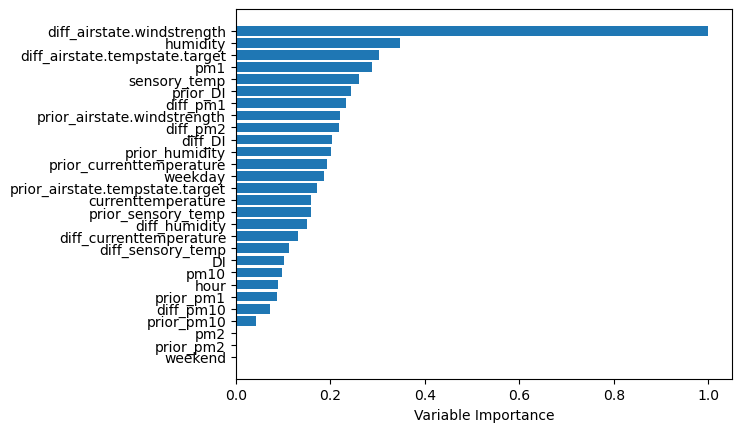

In [104]:
names = X.columns
featureImportance = xgb.feature_importances_

#가장 높은 중요도 기준으로 스케일링
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, names[sorted_idx])
plt.xlabel('Variable Importance')
plt.show()

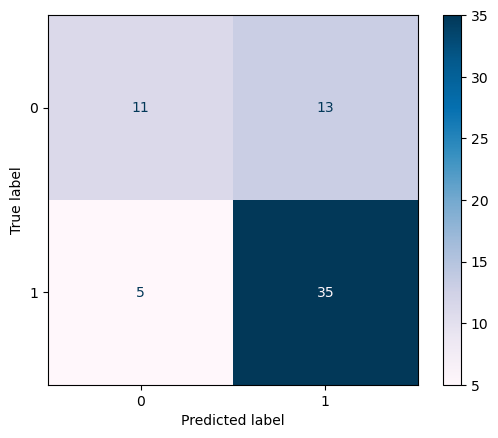

/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in construct

/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in construct

/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/

/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in construct

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/

/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in construct

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/

/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in construct

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/

/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in construct

In [105]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
plot_confusion_matrix(xgb, X_test, y_test,
                         include_values = True,
                         display_labels = ['0', '1'], # 목표변수 이름
                         cmap = 'PuBu') # 컬러맵

In [106]:
rf = RandomForestClassifier(random_state=42)
# 그리드 서치
param_grid = [{'n_estimators':[100],'max_features':range(1,10),'max_depth':range(4,12,2)}]
gs = GridSearchCV(rf,param_grid = param_grid, scoring='accuracy',cv = 3, n_jobs=-1,verbose=2)
gs.fit(X_resampled,y_resampled)
print('random forest parameter : ',gs.best_params_) # 최적 파라미터

Fitting 3 folds for each of 36 candidates, totalling 108 fits


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/deallab/anaconda3/lib/python3.8/

random forest parameter :  {'max_depth': 8, 'max_features': 9, 'n_estimators': 100}


In [107]:
rf = RandomForestClassifier(max_depth=8, max_features=9, n_estimators=100,random_state=42)
rf_model=rf.fit(X_resampled,y_resampled)
y_pred = rf_model.predict(X_test)

print(accuracy_score(y_test,y_pred))

0.671875


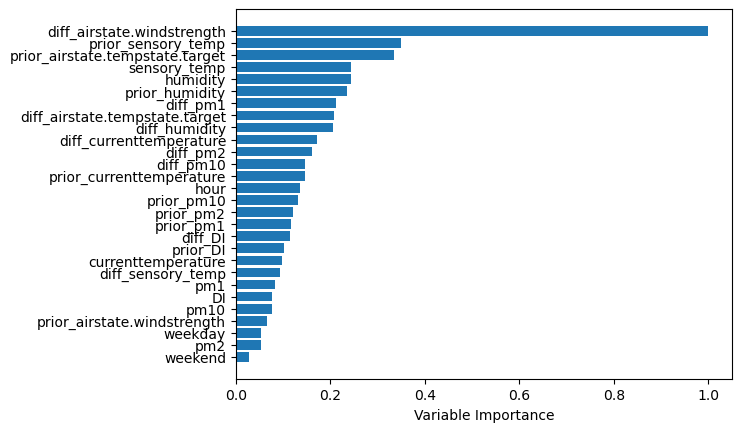

In [108]:
names = X.columns
featureImportance = rf.feature_importances_

#가장 높은 중요도 기준으로 스케일링
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, names[sorted_idx])
plt.xlabel('Variable Importance')
plt.show()

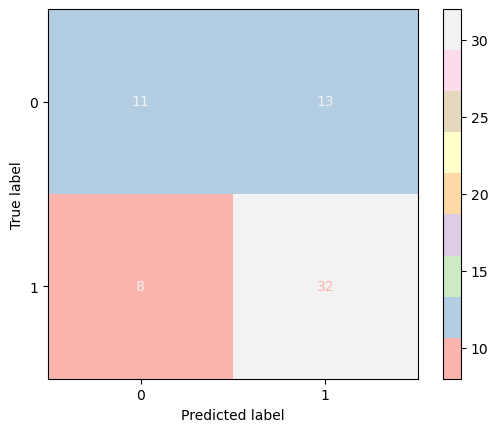

[CV] END ......max_depth=4, max_features=7, n_estimators=100; total time=   0.6s
[CV] END ......max_depth=4, max_features=1, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=8, max_features=9, n_estimators=100; total time=   0.5s
[CV] END .....max_depth=10, max_features=3, n_estimators=100; total time=   0.6s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=4, max_features=2, n_estimators=100; total time=   0.7s
[CV] END ......max_depth=4, max_features=3, n_estimators=100; total time=   0.6s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=4, max_features=6, n_estimators=100; total time=   0.6s
[CV] END .....max_depth=10, max_features=2, n_estimators=100; total time=   0.8s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=4, max_features=5, n_estimators=100; total time=   0.7s
[CV] END .....max_depth=10, max_features=2, n_estimators=100; total time=   0.6s
[CV] END ......max_depth=4, max_features=5, n_estimators=100; total time=   0.7s
[CV] END .....max_depth=10, max_features=2, n_estimators=100; total time=   0.7s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=4, max_features=9, n_estimators=100; total time=   0.6s
[CV] END .....max_depth=10, max_features=4, n_estimators=100; total time=   0.5s
[CV] END ......max_depth=4, max_features=4, n_estimators=100; total time=   0.6s
[CV] END .....max_depth=10, max_features=3, n_estimators=100; total time=   0.6s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=4, max_features=7, n_estimators=100; total time=   0.7s
[CV] END .....max_depth=10, max_features=4, n_estimators=100; total time=   0.6s
[CV] END ......max_depth=4, max_features=4, n_estimators=100; total time=   0.7s
[CV] END .....max_depth=10, max_features=4, n_estimators=100; total time=   0.7s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=6, max_features=1, n_estimators=100; total time=   0.7s
[CV] END ......max_depth=6, max_features=1, n_estimators=100; total time=   0.6s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=6, max_features=8, n_estimators=100; total time=   0.8s
[CV] END ......max_depth=4, max_features=9, n_estimators=100; total time=   0.5s
[CV] END .....max_depth=10, max_features=1, n_estimators=100; total time=   0.6s
[CV] END .....max_depth=10, max_features=7, n_estimators=100; total time=   0.4s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=4, max_features=4, n_estimators=100; total time=   0.5s
[CV] END ......max_depth=8, max_features=9, n_estimators=100; total time=   0.7s
[CV] END .....max_depth=10, max_features=5, n_estimators=100; total time=   0.6s
[CV] END ......max_depth=4, max_features=6, n_estimators=100; total time=   0.6s
[CV] END .....max_depth=10, max_features=3, n_estimators=100; total time=   0.8s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=4, max_features=8, n_estimators=100; total time=   0.7s
[CV] END .....max_depth=10, max_features=6, n_estimators=100; total time=   0.6s
[CV] END ......max_depth=6, max_features=1, n_estimators=100; total time=   0.6s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=4, max_features=5, n_estimators=100; total time=   0.6s
[CV] END .....max_depth=10, max_features=1, n_estimators=100; total time=   0.5s
[CV] END .....max_depth=10, max_features=7, n_estimators=100; total time=   0.5s
[CV] END ......max_depth=4, max_features=7, n_estimators=100; total time=   0.4s
[CV] END .....max_depth=10, max_features=1, n_estimators=100; total time=   0.5s
[CV] END .....max_depth=10, max_features=6, n_estimators=100; total time=   0.6s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=6, max_features=3, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=4, max_features=1, n_estimators=100; total time=   0.6s
[CV] END .....max_depth=10, max_features=5, n_estimators=100; total time=   0.7s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=4, max_features=1, n_estimators=100; total time=   0.6s
[CV] END .....max_depth=10, max_features=6, n_estimators=100; total time=   0.7s
[CV] END ......max_depth=4, max_features=2, n_estimators=100; total time=   0.6s
[CV] END ......max_depth=8, max_features=9, n_estimators=100; total time=   0.9s
[CV] END .....max_depth=10, max_features=9, n_estimators=100; total time=   0.5s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=6, max_features=5, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=6, max_features=2, n_estimators=100; total time=   0.6s
[CV] END .....max_depth=10, max_features=8, n_estimators=100; total time=   0.6s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=6, max_features=7, n_estimators=100; total time=   0.8s
[CV] END ......max_depth=6, max_features=4, n_estimators=100; total time=   0.7s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=8, max_features=1, n_estimators=100; total time=   0.5s
[CV] END ......max_depth=8, max_features=7, n_estimators=100; total time=   0.4s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=6, max_features=7, n_estimators=100; total time=   0.6s
[CV] END .....max_depth=10, max_features=5, n_estimators=100; total time=   0.8s
[CV] END ......max_depth=6, max_features=3, n_estimators=100; total time=   0.6s
[CV] END .....max_depth=10, max_features=7, n_estimators=100; total time=   0.7s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=8, max_features=3, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=4, max_features=9, n_estimators=100; total time=   0.8s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=6, max_features=7, n_estimators=100; total time=   0.5s
[CV] END ......max_depth=4, max_features=6, n_estimators=100; total time=   0.6s
[CV] END .....max_depth=10, max_features=9, n_estimators=100; total time=   0.6s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=4, max_features=3, n_estimators=100; total time=   0.6s
[CV] END ......max_depth=4, max_features=2, n_estimators=100; total time=   0.7s
[CV] END .....max_depth=10, max_features=8, n_estimators=100; total time=   0.6s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=6, max_features=4, n_estimators=100; total time=   0.6s
[CV] END ......max_depth=6, max_features=5, n_estimators=100; total time=   0.6s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=8, max_features=1, n_estimators=100; total time=   0.5s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=4, max_features=8, n_estimators=100; total time=   0.7s
[CV] END .....max_depth=10, max_features=8, n_estimators=100; total time=   0.7s
[CV] END ......max_depth=6, max_features=8, n_estimators=100; total time=   0.6s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=6, max_features=4, n_estimators=100; total time=   0.7s
[CV] END ......max_depth=4, max_features=8, n_estimators=100; total time=   0.7s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=8, max_features=6, n_estimators=100; total time=   0.7s
[CV] END ......max_depth=6, max_features=5, n_estimators=100; total time=   0.7s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=4, max_features=3, n_estimators=100; total time=   0.7s
[CV] END .....max_depth=10, max_features=9, n_estimators=100; total time=   0.7s
[CV] END ......max_depth=6, max_features=3, n_estimators=100; total time=   0.3s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=8, max_features=2, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=6, max_features=6, n_estimators=100; total time=   0.7s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=8, max_features=5, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=8, max_features=7, n_estimators=100; total time=   0.4s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=8, max_features=5, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=6, max_features=9, n_estimators=100; total time=   0.4s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=8, max_features=7, n_estimators=100; total time=   0.5s
[CV] END ......max_depth=8, max_features=2, n_estimators=100; total time=   0.4s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=6, max_features=8, n_estimators=100; total time=   0.6s
[CV] END ......max_depth=8, max_features=6, n_estimators=100; total time=   0.6s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=6, max_features=9, n_estimators=100; total time=   0.5s
[CV] END ......max_depth=6, max_features=2, n_estimators=100; total time=   0.3s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=8, max_features=3, n_estimators=100; total time=   0.2s
[CV] END ......max_depth=6, max_features=6, n_estimators=100; total time=   0.5s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=8, max_features=4, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=8, max_features=5, n_estimators=100; total time=   0.3s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=6, max_features=9, n_estimators=100; total time=   0.4s
[CV] END ......max_depth=6, max_features=2, n_estimators=100; total time=   0.4s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=8, max_features=6, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=6, max_features=6, n_estimators=100; total time=   0.3s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=8, max_features=1, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=8, max_features=3, n_estimators=100; total time=   0.4s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=8, max_features=2, n_estimators=100; total time=   0.3s
[CV] END ......max_depth=8, max_features=4, n_estimators=100; total time=   0.3s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=8, max_features=8, n_estimators=100; total time=   0.3s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=8, max_features=8, n_estimators=100; total time=   0.2s
[CV] END ......max_depth=8, max_features=4, n_estimators=100; total time=   0.2s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[CV] END ......max_depth=8, max_features=8, n_estimators=100; total time=   0.3s


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [109]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
plot_confusion_matrix(rf, X_test, y_test,
                         include_values = True,
                         display_labels = ['0', '1'], # 목표변수 이름
                         cmap = 'Pastel1') # 컬러맵